# Harmonic Motion

\begin{equation} \tag{1}
  m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
\end{equation}

\begin{equation}
  u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
\tag{2}
\end{equation}

\begin{equation}
  u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
\tag{3}
\end{equation}

\begin{equation}
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
\end{equation}

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
torch.manual_seed(15)


def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / ( 2* np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

In [3]:
class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [4]:
model = FCN(1, 1, 32, 3)
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
d, w0 = 2, 20
mu, k = 2 * d, w0 ** 2
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_iter = 15001

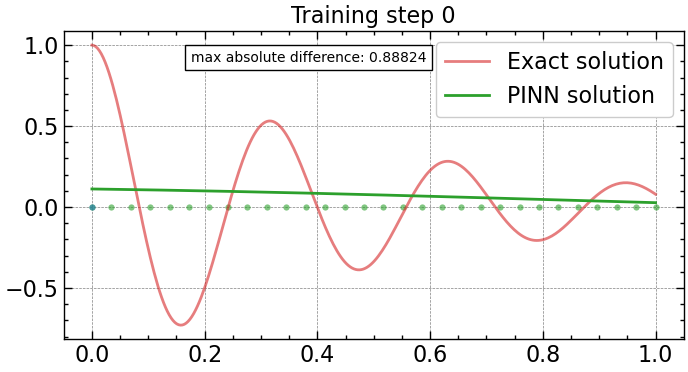

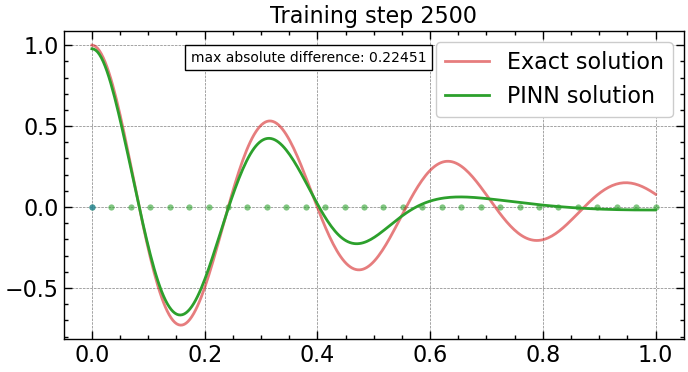

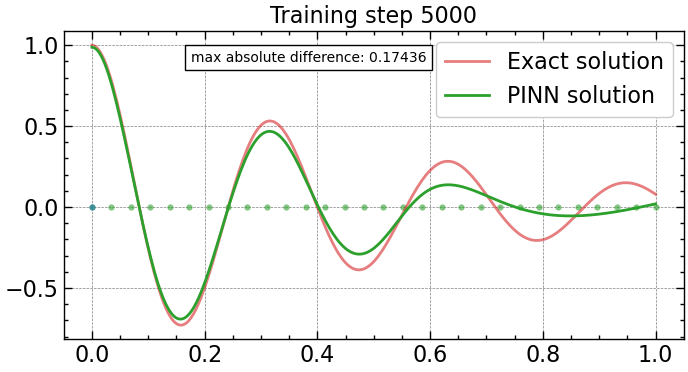

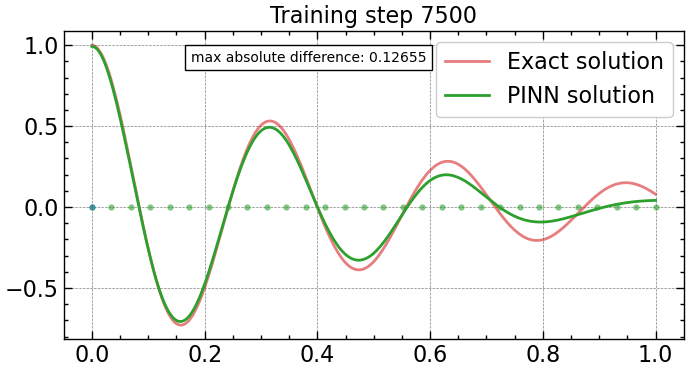

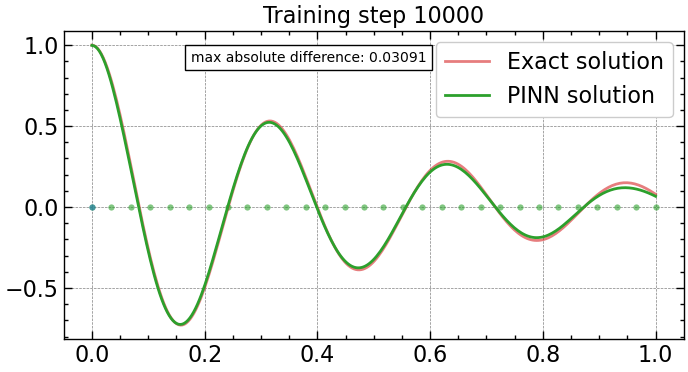

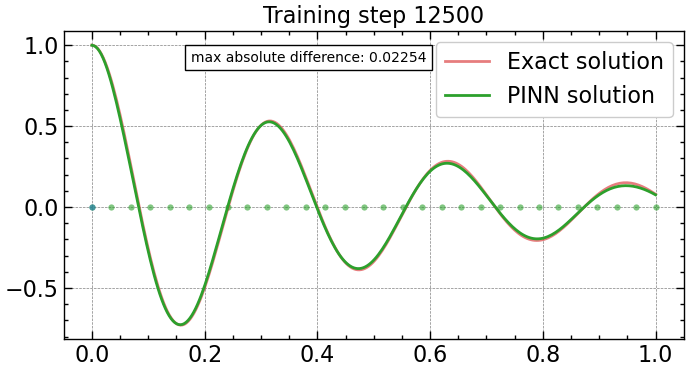

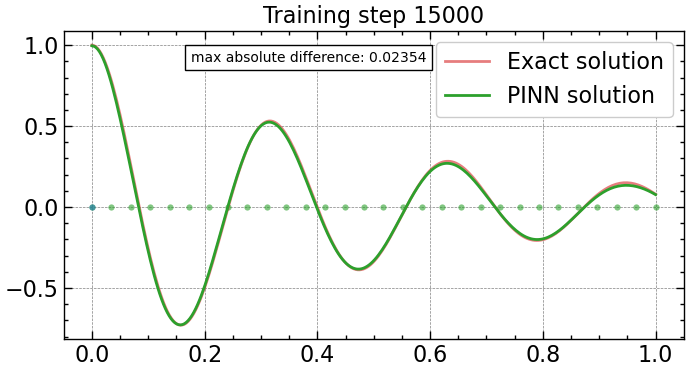

In [5]:
for i in range(num_iter):
    optimizer.zero_grad()

    u = model(t_boundary)
    loss1 = (torch.squeeze(u) - 1) ** 2

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0) ** 2

    u = model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

    lambda1, lambda2 = 1e-1, 1e-4
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    loss.backward()
    optimizer.step()

    if i % 2500 == 0:
        u = model(t_test).detach()
        diff = str(np.round(np.max(np.abs(u - u_exact).numpy()), 5))
        plt.figure(figsize=(8, 4))
        plt.scatter(t_physics.detach()[:, 0],
                    torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0],
                    torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:blue", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.text(0.175, 0.9, f'max absolute difference: {diff}', size=10, bbox=dict(facecolor='white', edgecolor='black'))
        plt.legend()
        plt.show()


In [ ]:
t_test = torch.linspace(0, 2, 600).view(-1, 1)
u = model(t_test).detach()
u_exact = exact_solution(d, w0, t_test)
diff = str(np.round(np.max(np.abs(u - u_exact).numpy()), 5))
plt.figure(figsize=(8, 4))
plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:red", alpha=0.6)
plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
plt.title(f"Training step {i}")
plt.text(0.175, 0.9, f'max absolute difference: {diff}', size=10, bbox=dict(facecolor='white', edgecolor='black'))

plt.legend()
plt.show()